In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import random

from CookieTTS.utils.dataset.utils import load_wav_to_torch, load_filepaths_and_text

# 1 - Load Dataset

In [13]:
import os
import random
from glob import glob
from CookieTTS.utils.dataset.utils import load_wav_to_torch
from CookieTTS.utils.audio.stft import STFT
from CookieTTS.utils.audio.audio_processing import window_sumsquare, dynamic_range_compression, dynamic_range_decompression

class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, model_config, directory, wildcard_filter = "*.wav", p_white_noise = 0.4, min_noise_str = 0.0, max_noise_str = 0.1):
        print("Finding Audio Files...")
        self.audio_files = glob( os.path.join(directory, "**", wildcard_filter), recursive=True)
        print("Done")
        
        random.seed(1234)
        random.shuffle(self.audio_files)
        self.len = len(self.audio_files)
        
        self.win_len = model_config['window_length']
        self.hop_len = model_config['hop_length']
        self.fil_len = model_config['filter_length']
        self.stft = STFT(filter_length=self.fil_len,
                                 hop_length=self.hop_len,
                                 win_length=self.win_len,)
        
        self.directory = directory
        self.wildcard_filter = wildcard_filter
        self.p_white_noise = p_white_noise
        self.min_noise_str = min_noise_str
        self.max_noise_str = max_noise_str
    
    def get_mel(self, audio):
        """Take audio and convert to spectrogram"""
        melspec = self.stft.transform(audio.unsqueeze(0), return_phase=False)[0].squeeze(0)
        return melspec
    
    def __getitem__(self, index):
        audio_path = self.audio_files[index]
        audio, sampling_rate, max_mag = load_wav_to_torch(audio_path) # load mono audio from file
        audio = audio / max_mag # normalize to range [-1, 1]
        
        #noisy_audio = audio.clone()
        #noisy_audio += torch.randn(*audio.shape) * random.uniform(self.min_noise_str, self.max_noise_str)
        #noisy_audio = noisy_audio.clamp(min=-0.999, max=0.999)
        #noisy_spect = dynamic_range_compression(self.get_mel(noisy_audio))
        
        spect = self.get_mel(audio)
        spect = dynamic_range_compression(spect)
        noisy_spect = spect.clone() + torch.randn(*spect.shape).abs() * random.uniform(self.min_noise_str, self.max_noise_str)
        #noisy_spect = dynamic_range_compression(noisy_spect)
        
        spect_length = spect.shape[1]
        return (spect, noisy_spect, spect_length)
    
    def __len__(self):
        return self.len

In [3]:
class MelCollate():
    def __init__(self):
        pass
    
    def __call__(self, batch):
        B = len(batch)
        lengths = [x[0].shape[1] for x in batch]
        n_mel = batch[0][0].shape[0]
        max_length = max(*lengths)
        b_spect = torch.zeros(B, n_mel, max_length)
        b_spect_noisy = torch.zeros(B, n_mel, max_length)
        
        for i in range(B):
            spect = batch[i][0]
            b_spect[i, :, :spect.shape[1]] = spect
            noisy_spect = batch[i][1]
            b_spect_noisy[i, :, :noisy_spect.shape[1]] = noisy_spect
        
        spect_lengths = torch.tensor(lengths)
        model_inputs = (b_spect, b_spect_noisy, spect_lengths)
        return model_inputs

# 2 - Init Model

In [4]:
class TemporalBlock(nn.Module):
    def __init__(self, input_dim, output_dim, n_layers, n_dim, kernel_w, bias=True, act_func=nn.LeakyReLU(negative_slope=0.4, inplace=True), dropout=0.0, res=False):
        super(TemporalBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            in_dim = input_dim if i == 0 else n_dim
            out_dim = output_dim if i+1 == n_layers else n_dim
            pad = (kernel_w - 1)//2
            conv = nn.Conv1d(in_dim, out_dim, kernel_w, padding=pad, bias=bias)
            self.layers.append(conv)
        self.act_func = act_func
        self.dropout = dropout
        self.res = res
        if self.res:
            assert input_dim == output_dim, 'residual connection requires input_dim and output_dim to match.'
    
    def forward(self, x): # [B, in_dim, T]
        skip = x
        
        for i, layer in enumerate(self.layers):
            is_last_layer = bool( i+1 == len(self.layers) )
            x = layer(x)
            if not is_last_layer:
                x = self.act_func(x)
            if self.dropout > 0.0 and self.training:
                x = F.dropout(x, p=self.dropout, training=self.training, inplace=True)
        if self.res:
            x += skip
        return x # [B, out_dim, T]


class NeuralDenoiser(nn.Module):
    def __init__(self, model_config):
        super(NeuralDenoiser, self).__init__()
        self.input_dim = (model_config['filter_length']//2) + 1
        self.device = "cuda"
        
        self.temporalblocks = nn.ModuleList()
        for i in range(model_config['n_blocks']):
            b_first_block = bool(i == 0)
            b_last_block = bool(i+1 == model_config['n_blocks'])
            in_dim  = self.input_dim if b_first_block else model_config['n_dim']
            out_dim = self.input_dim if b_last_block else model_config['n_dim']
            res = True if (model_config['residual_connections'] and in_dim == out_dim) else False
            n_layers = model_config['bottleneck_n_layers'] if b_first_block or b_last_block else model_config['n_layers']
            temp_block = TemporalBlock(in_dim, out_dim, n_layers, model_config['n_dim'],
                                       model_config['kernel_width'], bias = model_config['bias'],
                                       dropout = model_config['dropout'], res=res)
            self.temporalblocks.append(temp_block)
    
    def forward(self, inputs):
        _, noisy_spect, spect_lengths = inputs
        spect = noisy_spect
        assert spect.shape[1] == self.input_dim, f'input Tensor is wrong shape ({spect.shape}).'
        spect = spect.to(self.device)
        res_connection = spect
        
        for block in self.temporalblocks:
            spect = block(spect)
        
        return spect+res_connection

In [5]:
import torch
from CookieTTS.utils.model.utils import get_mask_from_lengths

class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()
    
    def forward(self, y, x):
        gt_spect, noisy_spect, lengths = x
        pred_spect = y
        
        mask = get_mask_from_lengths(lengths.cuda())
        mask = mask.expand(gt_spect.size(1), mask.size(0), mask.size(1))
        mask = mask.permute(1, 0, 2)
        #gt_spect.detach()[~mask] = 0.0
        #pred_spect.detach()[~mask] = 0.0
        #noisy_spect.detach()[~mask] = 0.0
        gt_spect = torch.masked_select(gt_spect.cuda(), mask)
        pred_spect = torch.masked_select(pred_spect.cuda(), mask)
        noisy_spect = torch.masked_select(noisy_spect.cuda(), mask)
        
        MAE = F.mse_loss(pred_spect, gt_spect)
        worst_MAE = F.mse_loss(noisy_spect, gt_spect)
        return MAE, worst_MAE

# 2.9 - Plot Data

In [6]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

def plot_data(data, title=None, figsize=(20, 3.5), range_=[-11.6, 2.0]):
    """
    data: list([height, width], [height, width], ...)
    """
    #for i in range(len(data)):
    #    data[i][0,0] = range_[0]
    #    data[i][0,1] = range_[1]
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        if title:
            axes[i].set_title(title[i])
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
    plt.show()
    %matplotlib inline

# 3 - Train and Eval

Config

In [16]:
model_config = {
    "audio_directory": r"H:\ClipperDatasetV2\SlicedDialogue\FiM\S1",
    "wildcard_filter": "*.wav",
    "batch_size": 4,
    "learning_rate": 5e-5,
    "window_length": 2048,
    "hop_length": 256,
    "filter_length": 2048,
    "p_white_noise": 0.4,
    "min_noise_strength": 0.01,
    "max_noise_strength": 1.0,
    "n_blocks": 12,
    "n_layers": 4,
    "bottleneck_n_layers": 1,
    "n_dim": 1024,
    "kernel_width": 9,
    "residual_connections": True,
    "bias": True,
    "dropout": 0.0,
}

The rest

In [17]:
from torch.utils.data import DataLoader

n_epochs = 1000

dataset = AudioDataset(model_config, model_config['audio_directory'], model_config['wildcard_filter'], model_config['p_white_noise'], model_config['min_noise_strength'], model_config['max_noise_strength'])

Finding Audio Files...
Done


In [19]:
# Initialize Training
collate_fn = MelCollate()
train_loader = DataLoader(dataset, num_workers=0, shuffle=True,
                              batch_size=model_config['batch_size'],
                              pin_memory=False, drop_last=True,
                              collate_fn=collate_fn)

criterion = LossFunction()

In [ ]:
# Initialize/Reset Model
model = NeuralDenoiser(model_config).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=model_config['learning_rate'])

iteration = 0
avg_improvement = 0.0
avg_training_loss = 2.0

Epoch: 0
[Iter 1964  ] [Training Loss 4.997 Avg 1.742] [Eg 0.274] [Improvement -4.72325626 Avg 15.45360090]
[Iter 1966  ] [Training Loss 25.101 Avg 4.293] [Eg 0.189] [Improvement -24.91164240 Avg 13.74131404]
[Iter 1968  ] [Training Loss 5.744 Avg 4.585] [Eg 0.356] [Improvement -5.38836539 Avg 12.92258726]
[Iter 1970  ] [Training Loss 2.698 Avg 4.487] [Eg 0.456] [Improvement -2.24191087 Avg 12.29024061]
[Iter 1972  ] [Training Loss 2.353 Avg 4.334] [Eg 0.565] [Improvement -1.78776687 Avg 11.71336881]
[Iter 1974  ] [Training Loss 2.190 Avg 4.102] [Eg 0.654] [Improvement -1.53638881 Avg 11.18843103]
[Iter 1976  ] [Training Loss 1.201 Avg 3.853] [Eg 0.645] [Improvement -0.55588073 Avg 10.70136450]
[Iter 1978  ] [Training Loss 0.906 Avg 3.581] [Eg 0.395] [Improvement -0.51069272 Avg 10.24596727]
[Iter 1980  ] [Training Loss 1.146 Avg 3.327] [Eg 0.275] [Improvement -0.87142804 Avg 9.81306977]
[Iter 1982  ] [Training Loss 0.978 Avg 3.094] [Eg 0.307] [Improvement -0.67158654 Avg 9.40305272]
[

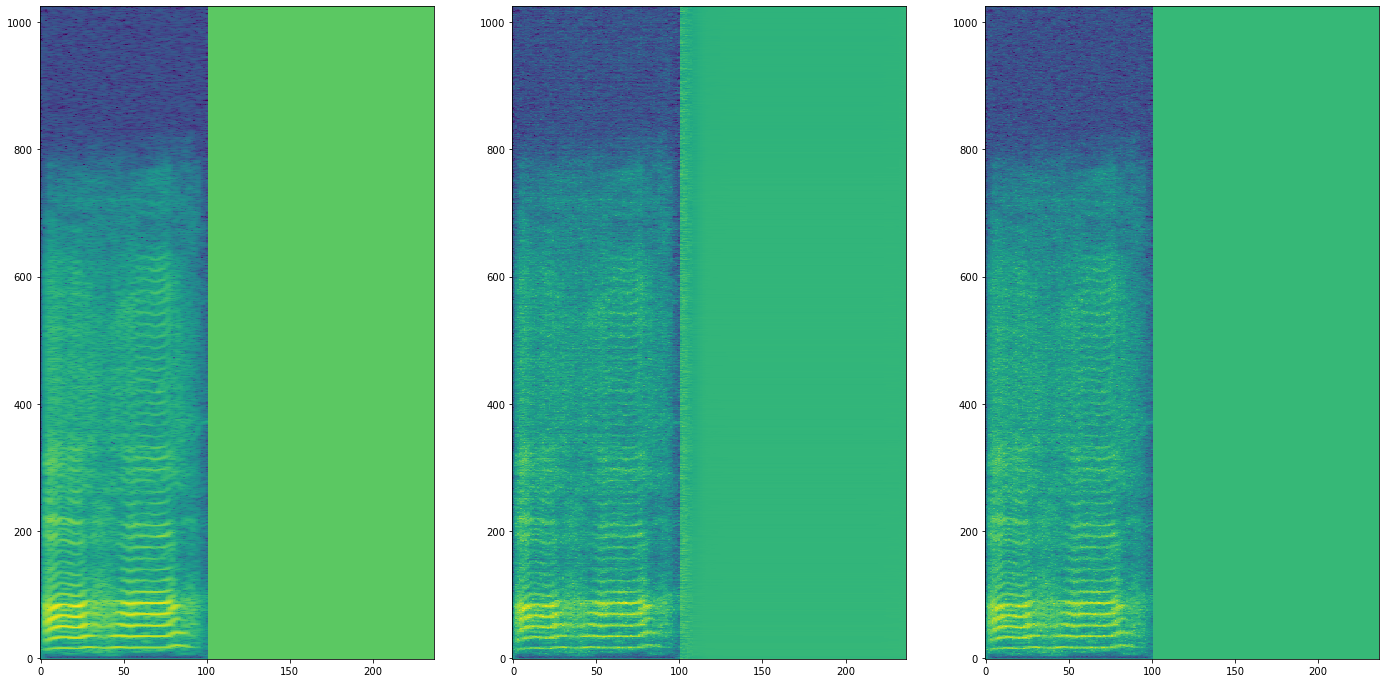

[Iter 2002  ] [Training Loss 0.468 Avg 1.449] [Eg 0.528] [Improvement 0.05991381 Avg 6.20632242]
[Iter 2004  ] [Training Loss 0.348 Avg 1.349] [Eg 0.216] [Improvement -0.13194390 Avg 5.95599905]
[Iter 2006  ] [Training Loss 0.404 Avg 1.259] [Eg 0.433] [Improvement 0.02925879 Avg 5.71898620]
[Iter 2008  ] [Training Loss 0.400 Avg 1.173] [Eg 0.280] [Improvement -0.11940289 Avg 5.48941630]
[Iter 2010  ] [Training Loss 0.361 Avg 1.096] [Eg 0.358] [Improvement -0.00282416 Avg 5.27108866]
[Iter 2012  ] [Training Loss 0.372 Avg 1.024] [Eg 0.317] [Improvement -0.05563435 Avg 5.05977387]
[Iter 2014  ] [Training Loss 0.318 Avg 0.961] [Eg 0.202] [Improvement -0.11580376 Avg 4.85730017]
[Iter 2016  ] [Training Loss 0.612 Avg 0.913] [Eg 0.818] [Improvement 0.20540756 Avg 4.66672961]
[Iter 2018  ] [Training Loss 0.441 Avg 0.868] [Eg 0.368] [Improvement -0.07308111 Avg 4.48312297]
[Iter 2020  ] [Training Loss 0.418 Avg 0.829] [Eg 0.536] [Improvement 0.11799580 Avg 4.31214192]
[Iter 2022  ] [Training 

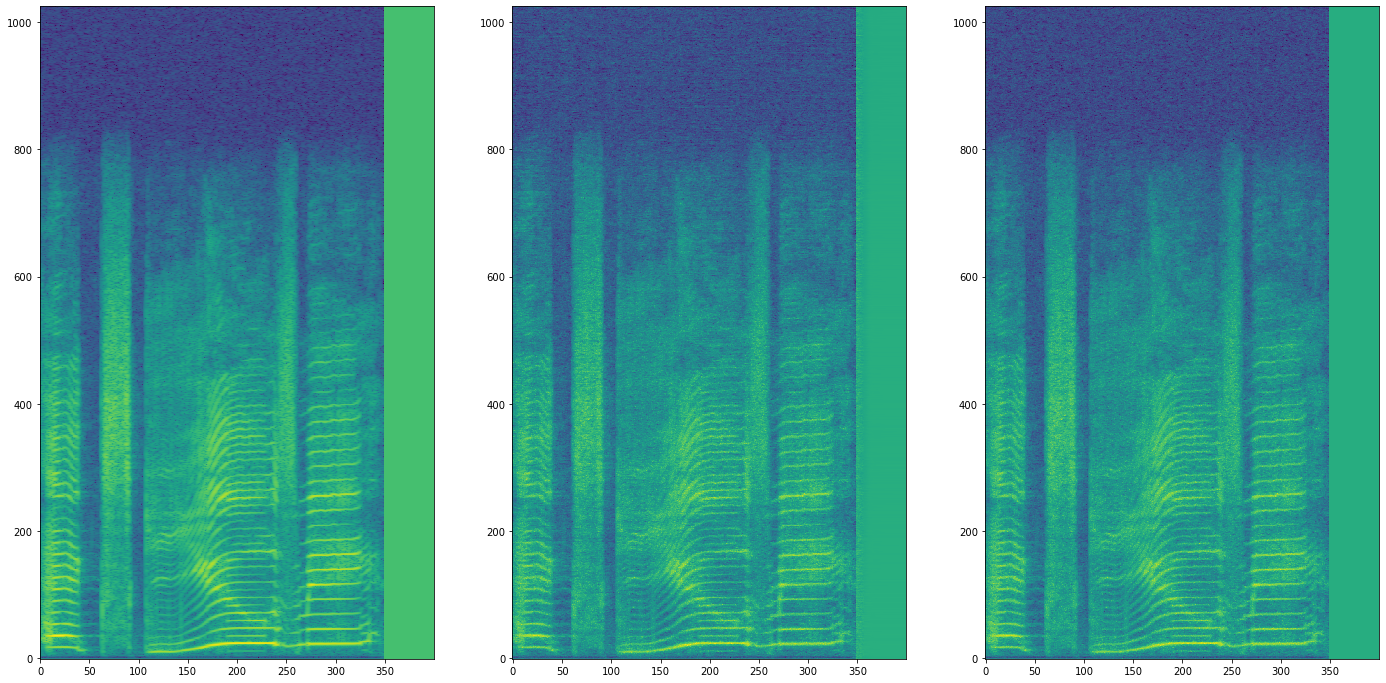

[Iter 2102  ] [Training Loss 0.358 Avg 0.350] [Eg 0.293] [Improvement -0.06548560 Avg 0.81050257]
[Iter 2104  ] [Training Loss 0.336 Avg 0.355] [Eg 0.431] [Improvement 0.09452924 Avg 0.78562528]
[Iter 2106  ] [Training Loss 0.439 Avg 0.360] [Eg 0.466] [Improvement 0.02770534 Avg 0.75623995]
[Iter 2108  ] [Training Loss 0.308 Avg 0.359] [Eg 0.329] [Improvement 0.02063030 Avg 0.72834107]
[Iter 2110  ] [Training Loss 0.515 Avg 0.362] [Eg 0.691] [Improvement 0.17641103 Avg 0.70312570]
[Iter 2112  ] [Training Loss 0.279 Avg 0.352] [Eg 0.308] [Improvement 0.02906063 Avg 0.67458084]
[Iter 2114  ] [Training Loss 0.202 Avg 0.347] [Eg 0.134] [Improvement -0.06786679 Avg 0.64749029]
[Iter 2116  ] [Training Loss 0.422 Avg 0.343] [Eg 0.553] [Improvement 0.13094661 Avg 0.62141096]
[Iter 2118  ] [Training Loss 0.412 Avg 0.345] [Eg 0.590] [Improvement 0.17766333 Avg 0.60101813]
[Iter 2120  ] [Training Loss 0.280 Avg 0.341] [Eg 0.258] [Improvement -0.02266189 Avg 0.57865427]
[Iter 2122  ] [Training Los

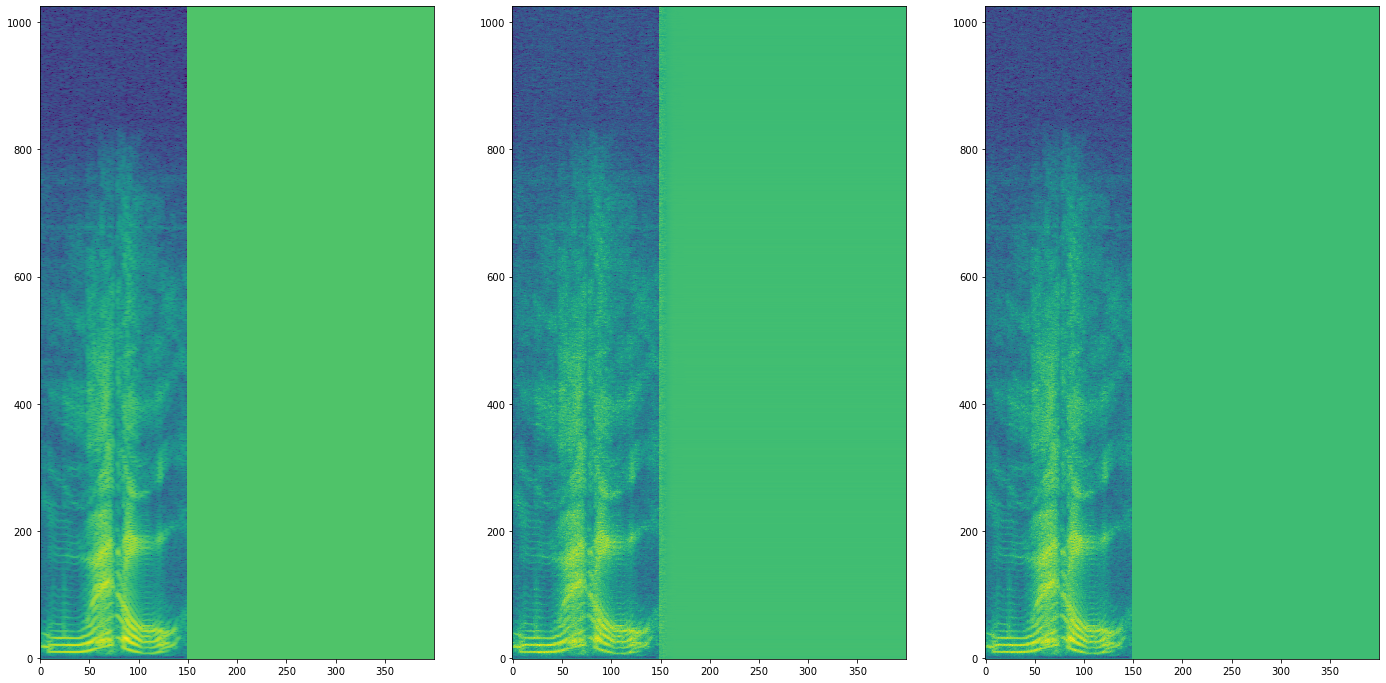

[Iter 2202  ] [Training Loss 0.378 Avg 0.312] [Eg 0.443] [Improvement 0.06501254 Avg 0.12682184]
[Iter 2204  ] [Training Loss 0.324 Avg 0.311] [Eg 0.398] [Improvement 0.07432339 Avg 0.12334799]
[Iter 2206  ] [Training Loss 0.219 Avg 0.304] [Eg 0.224] [Improvement 0.00438434 Avg 0.11783291]
[Iter 2208  ] [Training Loss 0.302 Avg 0.302] [Eg 0.346] [Improvement 0.04440755 Avg 0.11492807]
[Iter 2210  ] [Training Loss 0.451 Avg 0.308] [Eg 0.674] [Improvement 0.22297028 Avg 0.11452105]
[Iter 2212  ] [Training Loss 0.306 Avg 0.314] [Eg 0.363] [Improvement 0.05756786 Avg 0.11399365]
[Iter 2214  ] [Training Loss 0.247 Avg 0.307] [Eg 0.206] [Improvement -0.04085837 Avg 0.10950955]
[Iter 2216  ] [Training Loss 0.301 Avg 0.303] [Eg 0.281] [Improvement -0.01982313 Avg 0.10359895]
[Iter 2218  ] [Training Loss 0.450 Avg 0.309] [Eg 0.631] [Improvement 0.18048418 Avg 0.10251346]
[Iter 2220  ] [Training Loss 0.356 Avg 0.307] [Eg 0.451] [Improvement 0.09537396 Avg 0.10075075]
[Iter 2222  ] [Training Loss

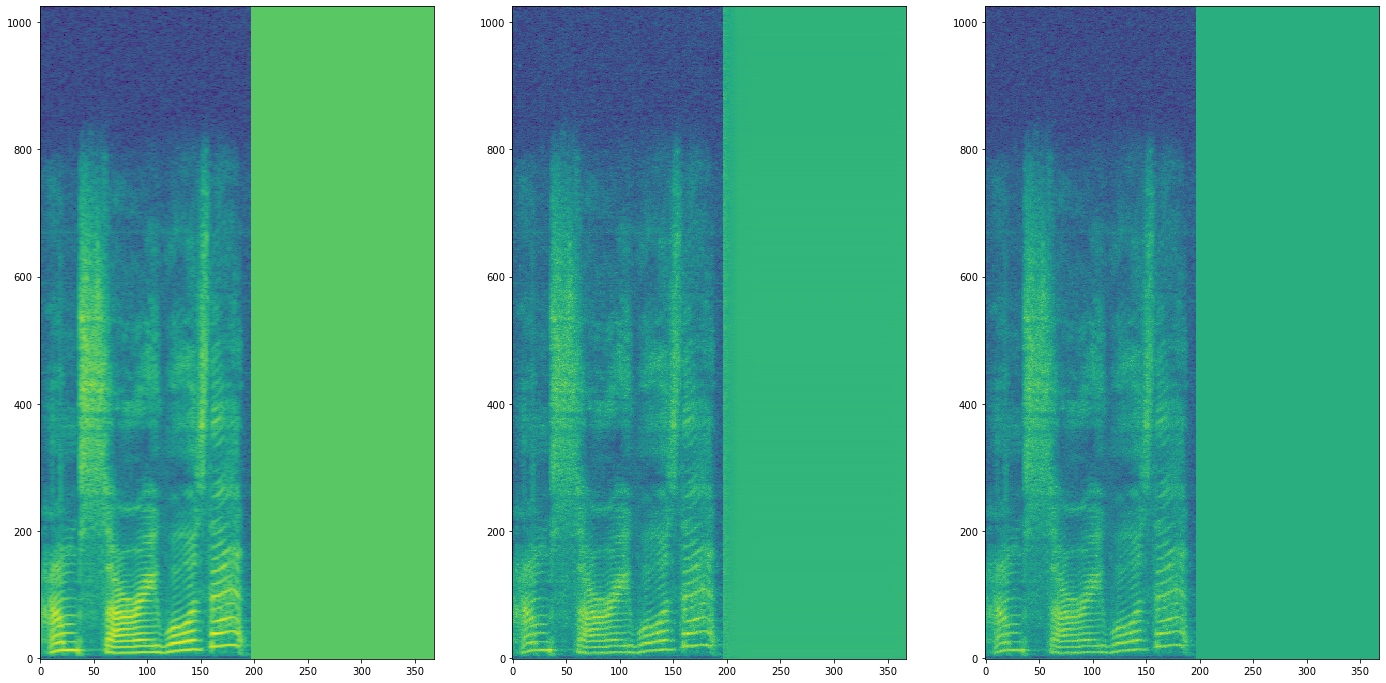

[Iter 2302  ] [Training Loss 0.308 Avg 0.316] [Eg 0.261] [Improvement -0.04643786 Avg 0.06460620]
[Iter 2304  ] [Training Loss 0.295 Avg 0.311] [Eg 0.324] [Improvement 0.02896068 Avg 0.06146421]
[Iter 2306  ] [Training Loss 0.211 Avg 0.306] [Eg 0.212] [Improvement 0.00055271 Avg 0.06069007]
[Iter 2308  ] [Training Loss 0.300 Avg 0.303] [Eg 0.366] [Improvement 0.06598103 Avg 0.06083428]
[Iter 2310  ] [Training Loss 0.350 Avg 0.300] [Eg 0.429] [Improvement 0.07851979 Avg 0.05947962]
[Iter 2312  ] [Training Loss 0.243 Avg 0.293] [Eg 0.160] [Improvement -0.08223052 Avg 0.05533193]
[Iter 2314  ] [Training Loss 0.361 Avg 0.295] [Eg 0.497] [Improvement 0.13590288 Avg 0.05458601]
[Iter 2316  ] [Training Loss 0.396 Avg 0.295] [Eg 0.573] [Improvement 0.17717111 Avg 0.05349988]
[Iter 2318  ] [Training Loss 0.339 Avg 0.303] [Eg 0.396] [Improvement 0.05731487 Avg 0.05609040]
[Iter 2320  ] [Training Loss 0.354 Avg 0.310] [Eg 0.544] [Improvement 0.18944815 Avg 0.06182944]
[Iter 2322  ] [Training Loss

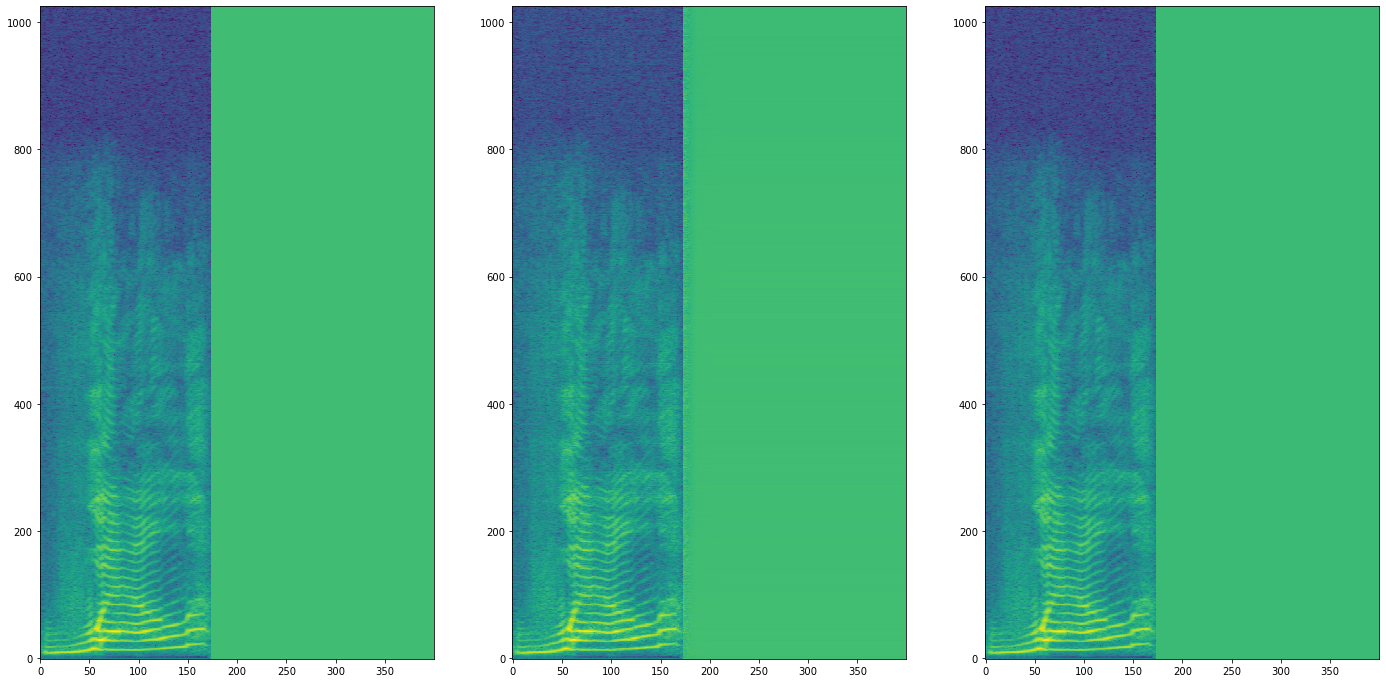

[Iter 2402  ] [Training Loss 0.333 Avg 0.281] [Eg 0.421] [Improvement 0.08758980 Avg 0.04064881]
[Iter 2404  ] [Training Loss 0.481 Avg 0.291] [Eg 0.568] [Improvement 0.08708671 Avg 0.03991894]
[Iter 2406  ] [Training Loss 0.227 Avg 0.289] [Eg 0.213] [Improvement -0.01373307 Avg 0.03891374]
[Iter 2408  ] [Training Loss 0.191 Avg 0.277] [Eg 0.221] [Improvement 0.02960292 Avg 0.03619533]
[Iter 2410  ] [Training Loss 0.198 Avg 0.268] [Eg 0.185] [Improvement -0.01262659 Avg 0.03317146]
[Iter 2412  ] [Training Loss 0.196 Avg 0.266] [Eg 0.168] [Improvement -0.02814607 Avg 0.03210829]
[Iter 2414  ] [Training Loss 0.189 Avg 0.259] [Eg 0.132] [Improvement -0.05718878 Avg 0.02808380]
[Iter 2416  ] [Training Loss 0.295 Avg 0.267] [Eg 0.283] [Improvement -0.01148608 Avg 0.03051520]
[Iter 2418  ] [Training Loss 0.165 Avg 0.267] [Eg 0.090] [Improvement -0.07466070 Avg 0.03112407]
[Iter 2420  ] [Training Loss 0.191 Avg 0.264] [Eg 0.200] [Improvement 0.00888312 Avg 0.03084574]
[Iter 2422  ] [Training 

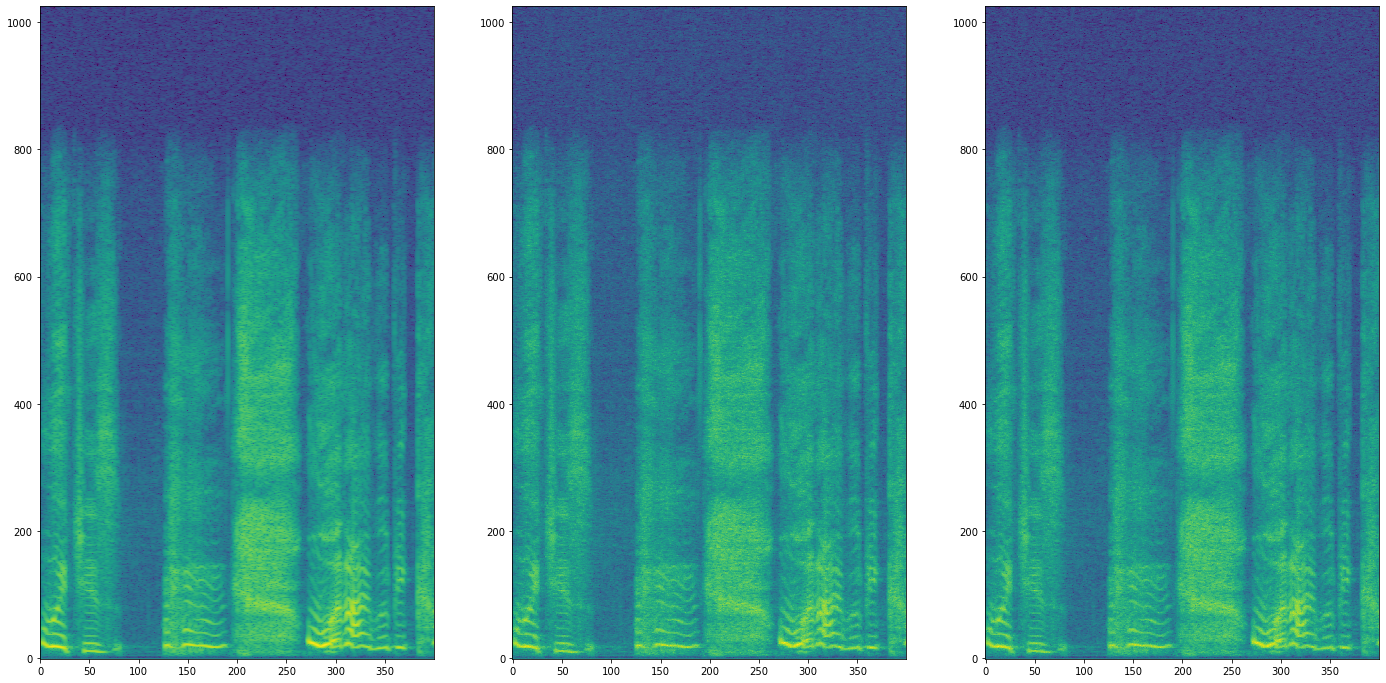

[Iter 2502  ] [Training Loss 0.331 Avg 0.294] [Eg 0.548] [Improvement 0.21709937 Avg 0.06344381]
[Iter 2504  ] [Training Loss 0.237 Avg 0.293] [Eg 0.232] [Improvement -0.00493245 Avg 0.06541408]
[Iter 2506  ] [Training Loss 0.349 Avg 0.300] [Eg 0.250] [Improvement -0.09929559 Avg 0.06239237]
[Iter 2508  ] [Training Loss 0.196 Avg 0.292] [Eg 0.147] [Improvement -0.04911825 Avg 0.05572011]
[Iter 2510  ] [Training Loss 0.432 Avg 0.302] [Eg 0.627] [Improvement 0.19505787 Avg 0.06060751]
[Iter 2512  ] [Training Loss 0.145 Avg 0.298] [Eg 0.100] [Improvement -0.04488744 Avg 0.06067543]
[Iter 2514  ] [Training Loss 0.269 Avg 0.290] [Eg 0.256] [Improvement -0.01271543 Avg 0.05724309]
[Iter 2516  ] [Training Loss 0.182 Avg 0.288] [Eg 0.124] [Improvement -0.05766665 Avg 0.05599849]
[Iter 2518  ] [Training Loss 0.202 Avg 0.277] [Eg 0.191] [Improvement -0.01126340 Avg 0.05261060]
[Iter 2520  ] [Training Loss 0.249 Avg 0.287] [Eg 0.307] [Improvement 0.05756819 Avg 0.05533425]
[Iter 2522  ] [Training

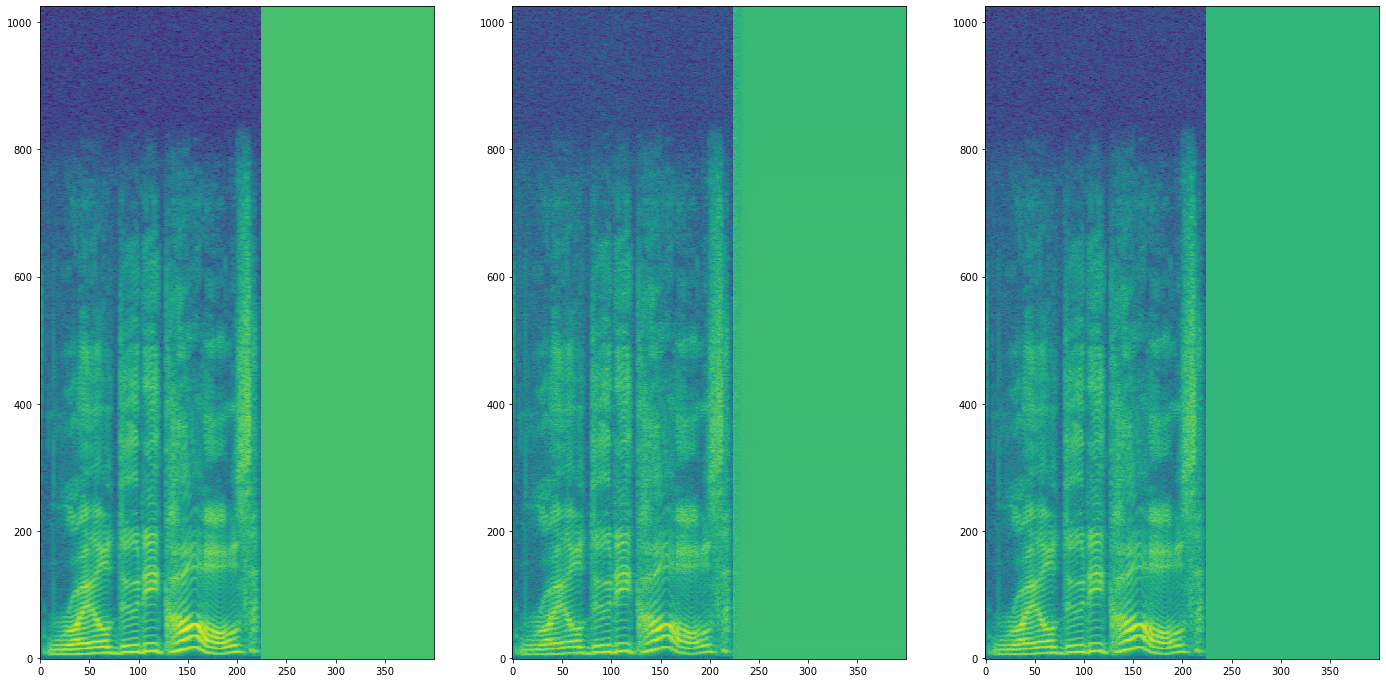

[Iter 2602  ] [Training Loss 0.264 Avg 0.291] [Eg 0.194] [Improvement -0.07085778 Avg 0.06618217]


KeyboardInterrupt: 

In [20]:
model.train()

for epoch in range(n_epochs):
    print(f"Epoch: {epoch}")
    for i, batch in enumerate(train_loader):
        learning_rate = 1e-5
        if iteration > 2000:
            learning_rate = 0.7e-5
        if iteration > 10000:
            learning_rate = 0.5e-5
        
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate
        model.zero_grad()
        outputs = model(batch)
        loss, example_loss = criterion(outputs, batch)
        reduced_loss = loss.item()
        reduced_example_loss = example_loss.item()
        loss.backward()
        optimizer.step()
        
        avg_training_loss = avg_training_loss*0.95 + reduced_loss*(1-0.95)
        improvement = reduced_example_loss-reduced_loss
        avg_improvement = avg_improvement*0.98 + improvement*(1-0.98)
        if iteration%2 == 0:
            print(f"[Iter {iteration:<6}] [Training Loss {reduced_loss:5.3f} Avg {avg_training_loss:5.3f}] [Eg {reduced_example_loss:5.3f}] [Improvement {improvement:5.8f} Avg {avg_improvement:5.8f}]")
        if iteration%100 == 0:
            plot_data([x[0][:,:400].float().cpu().detach().numpy() for x in batch[0:1]]+\
                      [outputs[0][:,:400].float().cpu().detach().numpy()]+\
                      [x[0][:,:400].float().cpu().detach().numpy() for x in batch[1:2]],
                      figsize=(24, 12))
        iteration+=1

# 4 - Test on WaveGlow

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

scale = 2
kernel_size = 2

x = torch.ones(1, 1, 6)
print(x)
print(x.shape)
tconv = nn.ConvTranspose1d(1, 1, kernel_size, scale, (kernel_size-scale)//2,
                                               bias=False, padding_mode='zeros')
tconv.weight.detach().mul_(0.)
tconv.weight.detach().add_(1.)

x = tconv(x)
print(x)
print(x.shape)

x = tconv(x)
print(x)
print(x.shape)

tensor([[[1., 1., 1., 1., 1., 1.]]])
torch.Size([1, 1, 6])
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],
       grad_fn=<SqueezeBackward1>)
torch.Size([1, 1, 12])
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SqueezeBackward1>)
torch.Size([1, 1, 24])


In [30]:
list(range(10))[1:-1]

[1, 2, 3, 4, 5, 6, 7, 8]

In [28]:
type([1,2,3]) == list

True

In [69]:
import torch
# https://www.desmos.com/calculator/4nac7kvt7p
# Squash smaller values together so that loss is lower on quieter parts of the spectrogram.

def vol_rescale_loss(mel, power=0.5, min=-11.55):
    mel = mel + (power/(-min*2))*(mel**2)
    return mel

mel = torch.arange(-11.5, 4.5)
mel_scaled = vol_rescale_loss(mel, power=0.5)

print(torch.stack((mel, mel_scaled), dim=1))

tensor([[-11.5000,  -8.6374],
        [-10.5000,  -8.1136],
        [ -9.5000,  -7.5465],
        [ -8.5000,  -6.9361],
        [ -7.5000,  -6.2825],
        [ -6.5000,  -5.5855],
        [ -5.5000,  -4.8452],
        [ -4.5000,  -4.0617],
        [ -3.5000,  -3.2348],
        [ -2.5000,  -2.3647],
        [ -1.5000,  -1.4513],
        [ -0.5000,  -0.4946],
        [  0.5000,   0.5054],
        [  1.5000,   1.5487],
        [  2.5000,   2.6353],
        [  3.5000,   3.7652]])


In [38]:
import iso226
import math
x = iso226.iso226_spl_itpl(L_N=60, hfe=True, k=3)

print(f"{'Freq':5} | {'SPL':8} | {'Relative Percieved Loudness':8}")
for i in range(0, 24000, 10):
    print(f"{i:5} | {x(i):8.4f} | {(2**(60./10))/(2**(x(i)/10)):5.4f}")

Freq  | SPL      | Relative Percieved Loudness
    0 | 149.8585 | 0.0020
   10 | 125.1071 | 0.0110
   20 | 109.5113 | 0.0323
   30 | 100.1307 | 0.0619
   40 |  94.1773 | 0.0936
   50 |  89.9635 | 0.1253
   60 |  86.7665 | 0.1564
   70 |  84.1975 | 0.1869
   80 |  82.0534 | 0.2168
   90 |  80.2258 | 0.2461
  100 |  78.6546 | 0.2744
  110 |  77.2935 | 0.3016
  120 |  76.1046 | 0.3275
  130 |  75.0522 | 0.3523
  140 |  74.1091 | 0.3761
  150 |  73.2560 | 0.3990
  160 |  72.4743 | 0.4212
  170 |  71.7481 | 0.4429
  180 |  71.0724 | 0.4642
  190 |  70.4452 | 0.4848
  200 |  69.8643 | 0.5047
  210 |  69.3274 | 0.5239
  220 |  68.8303 | 0.5422
  230 |  68.3688 | 0.5599
  240 |  67.9384 | 0.5768
  250 |  67.5348 | 0.5932
  260 |  67.1541 | 0.6090
  270 |  66.7943 | 0.6244
  280 |  66.4537 | 0.6393
  290 |  66.1310 | 0.6538
  300 |  65.8245 | 0.6678
  310 |  65.5326 | 0.6815
  320 |  65.2540 | 0.6948
  330 |  64.9876 | 0.7077
  340 |  64.7334 | 0.7203
  350 |  64.4911 | 0.7325
  360 |  64.2604 

In [58]:
model_config = {
    "sampling_rate": 48000,
    "filter_length": 2400,
}


iso226_spl_from_freq = iso226.iso226_spl_itpl(L_N=60, hfe=True)# get InterpolatedUnivariateSpline for Perc Sound Pressure Level at Difference Frequencies with 60DB ref.
freq_weights = [(2**(60./10))/(2**(iso226_spl_from_freq(freq)/10)) for freq in np.linspace(0, model_config['sampling_rate']//2, (model_config['filter_length']//2)+1)]
print(len(freq_weights))
print("\n".join([str(x) for x in freq_weights]))

1201
0.0019723775907517695
0.03232664896659515
0.09357507685338107
0.1564042906124358
0.21683355373707539
0.274435331969148
0.3274938487552098
0.37607562048432663
0.421196548663551
0.46418097753677934
0.5047245165425519
0.542226976621142
0.5768057926647929
0.6090311655253627
0.6393274623632555
0.6678309762731613
0.6947674526268561
0.7202946977769744
0.7443007399304995
0.7666567958674925
0.7872536101822974
0.8060470739644593
0.8232005049833674
0.8389611443457584
0.8536121395489686
0.8674677812268482
0.8808058654968516
0.8936659888813108
0.9060268781290206
0.9178683311174513
0.9291712744275854
0.9399178162272318
0.9500910260551519
0.959669004050594
0.9686246292631433
0.9769314320137045
0.9845639757215111
0.991497972495854
0.9977103971788093
1.003179599168992
1.0078854113455287
1.0117985985927211
1.0148487282672867
1.0169560312595143
1.018042642296931
1.018033322626999
1.0168562245877824
1.0144436901371847
1.0107330739953797
1.00566758066508
0.9991971032698416
0.9913204893850713
0.9822075

In [57]:
import numpy as np
list(np.linspace(0, model_config['sampling_rate']//2, (model_config['filter_length']//2)+1))

[0.0,
 20.0,
 40.0,
 60.0,
 80.0,
 100.0,
 120.0,
 140.0,
 160.0,
 180.0,
 200.0,
 220.0,
 240.0,
 260.0,
 280.0,
 300.0,
 320.0,
 340.0,
 360.0,
 380.0,
 400.0,
 420.0,
 440.0,
 460.0,
 480.0,
 500.0,
 520.0,
 540.0,
 560.0,
 580.0,
 600.0,
 620.0,
 640.0,
 660.0,
 680.0,
 700.0,
 720.0,
 740.0,
 760.0,
 780.0,
 800.0,
 820.0,
 840.0,
 860.0,
 880.0,
 900.0,
 920.0,
 940.0,
 960.0,
 980.0,
 1000.0,
 1020.0,
 1040.0,
 1060.0,
 1080.0,
 1100.0,
 1120.0,
 1140.0,
 1160.0,
 1180.0,
 1200.0,
 1220.0,
 1240.0,
 1260.0,
 1280.0,
 1300.0,
 1320.0,
 1340.0,
 1360.0,
 1380.0,
 1400.0,
 1420.0,
 1440.0,
 1460.0,
 1480.0,
 1500.0,
 1520.0,
 1540.0,
 1560.0,
 1580.0,
 1600.0,
 1620.0,
 1640.0,
 1660.0,
 1680.0,
 1700.0,
 1720.0,
 1740.0,
 1760.0,
 1780.0,
 1800.0,
 1820.0,
 1840.0,
 1860.0,
 1880.0,
 1900.0,
 1920.0,
 1940.0,
 1960.0,
 1980.0,
 2000.0,
 2020.0,
 2040.0,
 2060.0,
 2080.0,
 2100.0,
 2120.0,
 2140.0,
 2160.0,
 2180.0,
 2200.0,
 2220.0,
 2240.0,
 2260.0,
 2280.0,
 2300.0,
 2320.0,
 23

In [51]:
(model_config['filter_length']//2)+1

1201

In [35]:
x

In [3]:
import os

paths = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.2\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.2\libnvvp;C:\ffmpeg\bin;C:\Program Files (x86)\sox-14-4-2;C:\ffmpeg\bin;D:\TTS_Training\Requirements\cudnn\cudnn-10.1-windows7-x64-v7.6.2.24\cuda\bin;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\Program Files (x86)\Intel\iCLS Client\;C:\Program Files\Intel\iCLS Client\;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Program Files\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Users\Administrator\.dnx\bin;C:\Program Files\Microsoft DNX\Dnvm\;C:\Program Files\Microsoft SQL Server\120\Tools\Binn\;C:\Program Files\NVIDIA Corporation\Nsight Compute 2019.4.0\;C:\Program Files\Prio;C:\Program Files (x86)\WinMerge;C:\Program Files\nodejs\;D:\Miniconda;C:\Program Files\NVIDIA Corporation\Nsight Compute 2019.5.0\;C:\Program Files\Git\cmd;D:\Downloads\sde-external-8.56.0-2020-07-05-win".split(";")
for path in paths:
    if not os.path.exists(path):
        print(path)

new_paths = [x for x in paths if os.path.exists(path)]
print(";".join(new_paths))

D:\TTS_Training\Requirements\cudnn\cudnn-10.1-windows7-x64-v7.6.2.24\cuda\bin
C:\Users\Administrator\.dnx\bin
C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.2\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.2\libnvvp;C:\ffmpeg\bin;C:\Program Files (x86)\sox-14-4-2;C:\ffmpeg\bin;D:\TTS_Training\Requirements\cudnn\cudnn-10.1-windows7-x64-v7.6.2.24\cuda\bin;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\Program Files (x86)\Intel\iCLS Client\;C:\Program Files\Intel\iCLS Client\;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Program Files\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL;C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\IPT;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System3